#✔️ Problem Formulation:
We need to predict both `the price` and `type` of an aparement/house (Target variables) of airbnb company based on its overview summary and image (Independent variables). The price is encoded into 3 classes [0,1,2] so we'll work on it with classification methods.
In this problem we can mainly use CONVNETS for images and for the summary overview we can use sequential models like GRU and LSTMs.


This problem is **multimodal** as it has two different types of data as input and it i also **multi-task** as it predicts two different outputs.

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c cisc-873-dm-f22-a4

 92% 556M/604M [00:00<00:00, 1.16GB/s]
100% 604M/604M [00:00<00:00, 1.16GB/s]


In [5]:
!unzip cisc-873-dm-f22-a4.zip

Streaming output truncated to the last 5000 lines.
  inflating: a4/img_train/3366.jpg   
  inflating: a4/img_train/3367.jpg   
  inflating: a4/img_train/3368.jpg   
  inflating: a4/img_train/3369.jpg   
  inflating: a4/img_train/337.jpg    
  inflating: a4/img_train/3370.jpg   
  inflating: a4/img_train/3371.jpg   
  inflating: a4/img_train/3372.jpg   
  inflating: a4/img_train/3373.jpg   
  inflating: a4/img_train/3374.jpg   
  inflating: a4/img_train/3375.jpg   
  inflating: a4/img_train/3376.jpg   
  inflating: a4/img_train/3377.jpg   
  inflating: a4/img_train/3378.jpg   
  inflating: a4/img_train/3379.jpg   
  inflating: a4/img_train/338.jpg    
  inflating: a4/img_train/3380.jpg   
  inflating: a4/img_train/3381.jpg   
  inflating: a4/img_train/3382.jpg   
  inflating: a4/img_train/3383.jpg   
  inflating: a4/img_train/3384.jpg   
  inflating: a4/img_train/3385.jpg   
  inflating: a4/img_train/3386.jpg   
  inflating: a4/img_train/3387.jpg   
  inflating: a4/img_train/3388.jpg   

# Importing libraries and investigating data

In [ ]:
import os
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
import os
import numpy as np
from ast import literal_eval

In [ ]:
#Reading data
df = pd.read_csv('/content/a4/train_xy.csv')
df_test = pd.read_csv('/content/a4/test_x.csv')

In [ ]:
#Printing few lines of the data
df.head(5)

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0


In [ ]:
# Print dataframe size
df.shape

(7627, 4)

In [ ]:
#Checking for nans
df.isna().sum()

,0
summary,301
image,0
type,0
price,0


In [ ]:
#Checking for duplicates
df.duplicated().sum()

np.int64(0)

# Data Preprocessing

First, let's encode the 'type' column.

In [ ]:
df['type'].unique()

array(['Apartment', 'House', 'Townhouse', 'Condominium', 'Loft',
       'Serviced apartment', 'Bungalow', 'Bed and breakfast',
       'Casa particular (Cuba)', 'Boutique hotel', 'Villa', 'Guest suite',
       'Hostel', 'Hotel', 'Guesthouse', 'Cottage', 'Other', 'Aparthotel',
       'Tiny house', 'Boat', 'Cabin', 'Earth house', 'Camper/RV',
       'Castle'], dtype=object)

In [ ]:
df['type'] = df['type'].astype('category').cat.codes

# Get number of unique values on target variables 'type' and 'price'

len_type=df['type'].nunique()
len_price=df.price.nunique()

print (len_type)
print (len_price)

24
3


In [ ]:
df['type']

0        1
1        1
2        1
3        1
4        1
        ..
7622     1
7623     1
7624     1
7625     1
7626    17
Name: type, Length: 7627, dtype: int8

Since we have text and image files we'll have different preprocessing for each.


**Image data:** Resize

**Text data:** Tokenization and convert to integer IDs

In [ ]:
# preprocess image data
import os
#'/content/a4/img_train/100.jpg'
def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64))
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64, 2))
    return arr


# loading images:
x_train_image = np.array([load_image(i) for i in tqdm('/content/a4/'+df.image)])

# loading overview: (force convert some of the non-string cell to string)
x_train_text = df.summary.astype('str')

# get type
y_train_type = df['type']

# get price category
y_train_price = df['price']

  0%|          | 0/7627 [00:00<?, ?it/s]

In [ ]:
y_train_type.unique()

array([ 1, 17, 22, 10, 18, 20,  5,  2,  8,  4, 23, 13, 15, 16, 14, 11, 19,
        0, 21,  3,  6, 12,  7,  9], dtype=int8)

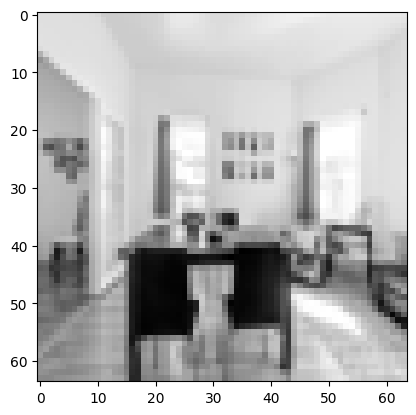

In [ ]:
# check image loading
import matplotlib.pyplot as plt

#[no of image,rows,columns,channels]
plt.imshow(x_train_image[0, :, :, 0],cmap='gray');

In [ ]:
# preprocess text data
import tensorflow as tf
tf.random.set_seed(1234)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pprint import pprint

vocab_size = 40000
max_len = 100


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train_text)


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )

#x_vl_text_id = _preprocess(x_vl_text)
# padding is done inside:
x_train_text_id = _preprocess(x_train_text)

print(x_train_text_id.shape)

(7627, 100)


In [ ]:
# we can use the tokenizer to convert IDs to words.
pprint(tokenizer.sequences_to_texts(x_train_text_id[:5]))

['spacious sunny and cozy modern apartment in the heart of montreal this 3 '
 'bedroom centrally located in the very popular plateau mont royal '
 'neighborhood in the middle of prince arthur pedestrian only street close to '
 'all amenities restaurants coffee house bars clubs shopping universities '
 'subway stations experience montreal like a real local resident be in the '
 'heart of the action grand prix week grill saint laurent festival mural 2019 '
 'and so much more',
 'located in one of the most vibrant and accessible locations of downtown '
 'montreal this one bedroom condo will not only impress you but leave you with '
 'one of the most memorable experiences it is walking distance of the popular '
 'sainte catherine street the bell center the old port lachine canal '
 'bonaventure metro and much much more',
 'logement coquet et douillet à 10 minutes du centre ville de montréal '
 'épicerie pharmacie saq restaurants et transports en communs à proximité deux '
 'chambres fermée

In [ ]:
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


# Building a Learning model

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam


# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding of 100 vector space
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
averaged = Lambda(lambda x: tf.reduce_mean(x, axis=1))(embedded)


# simple conv2d of 64 filter each of dimension 16x16
cov = Conv2D(64, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)


# fusion - combinig both
fused = Concatenate(axis=-1)([averaged, flattened])

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'summary' mapping to value <KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor_12> which has name 'keras_tensor_12'. Change the tensor name to 'summary' (via `Input(..., name='summary')`)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'image' mapping to value <KerasTensor shape=(None, 64, 64, 2), dtype=float32, sparse=False, name=keras_tensor_13> which has name 'keras_tensor_13'. Change the tensor name to 'image' (via `Input(..., name='image')`)
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 49, 49,    │     32,832 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 100)  │  4,000,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 3, 3, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 100)       │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 576)       │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 676)       │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price (Dense)       │ (None, 3)         │      2,031 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type (Dense)        │ (None, 24)        │     16,248 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,051,111 (15.45 MB)

 Trainable params: 4,051,111 (15.45 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training


In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, mode='min' )
    ],
    verbose=1
)

Epoch 1/20
763/763 ━━━━━━━━━━━━━━━━━━━━ 114s 150ms/step - loss: 17.2083 - price_SparseCategoricalAccuracy: 0.5002 - price_loss: 12.2291 - type_SparseCategoricalAccuracy: 0.5713 - type_loss: 22.1874 - val_loss: 27.0840 - val_price_SparseCategoricalAccuracy: 0.6186 - val_price_loss: 20.4655 - val_type_SparseCategoricalAccuracy: 0.7647 - val_type_loss: 33.7036
Epoch 2/20
763/763 ━━━━━━━━━━━━━━━━━━━━ 112s 146ms/step - loss: 26.7684 - price_SparseCategoricalAccuracy: 0.5170 - price_loss: 16.1979 - type_SparseCategoricalAccuracy: 0.5750 - type_loss: 37.3389 - val_loss: 13.7649 - val_price_SparseCategoricalAccuracy: 0.5865 - val_price_loss: 8.4764 - val_type_SparseCategoricalAccuracy: 0.5714 - val_type_loss: 19.0597
Epoch 3/20
763/763 ━━━━━━━━━━━━━━━━━━━━ 110s 145ms/step - loss: 22.4433 - price_SparseCategoricalAccuracy: 0.5242 - price_loss: 16.3917 - type_SparseCategoricalAccuracy: 0.5776 - type_loss: 28.4949 - val_loss: 14.7827 - val_price_SparseCategoricalAccuracy: 0.5760 - val_price_loss:

## Data Preprocessing (Testing)

Here we use the trained tokenizer to pre-process the testing set.

In [ ]:
# loading images:
x_test_image = np.array([load_image(i) for i in tqdm('/content/a4/img_test'+df_test.image)])

# loading overview: (force convert some of the non-string cell to string)
x_test_text = _preprocess(df_test.summary.astype('str'))

  0%|          | 0/7360 [00:00<?, ?it/s]

## Predition

We can use the model to predict the testing samples.

In [ ]:
# Predition
# we can do prediction on training set
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


# probabilities
type_predicted = y_predict['type']
print(type_predicted)

# categories
type_category_predicted = np.argmax(type_predicted, axis=1)
print(type_category_predicted)

230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step
[[9.9999994e-01 1.4705282e-08 2.7206795e-14]
 [9.9999994e-01 3.8960822e-12 2.4783724e-19]
 [9.9999982e-01 6.1152569e-08 4.3237525e-13]
 ...
 [9.9999923e-01 6.6045430e-07 6.1853131e-14]
 [9.9999994e-01 1.9678365e-12 6.6105753e-17]
 [9.9898076e-01 1.0192086e-03 9.1322172e-10]]
[0 0 0 ... 0 0 0]
[[2.2315244e-22 9.9999994e-01 9.3937060e-11 ... 3.3514606e-15
  2.1689293e-17 6.6934847e-11]
 [4.8907122e-29 9.9999994e-01 1.5090681e-13 ... 1.9725343e-19
  3.7426500e-22 8.4140445e-14]
 [3.1308379e-20 9.9999923e-01 1.4560948e-08 ... 2.4538016e-13
  1.8125959e-15 1.2675819e-08]
 ...
 [4.2475772e-25 9.9999994e-01 6.9539353e-12 ... 3.1998010e-17
  2.8637416e-20 7.0932401e-12]
 [6.1443283e-21 9.9999982e-01 2.5797928e-09 ... 1.3819779e-13
  4.8837925e-15 1.1948237e-09]
 [2.6534227e-20 9.9999994e-01 1.1447205e-11 ... 7.4416689e-15
  3.2226467e-17 1.0938782e-11]]
[1 1 1 ... 1 1 1]


In [ ]:
# Submission file
pd.DataFrame(
    {'id': df_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission_org.csv', index=False)

##Observation
The model got 0.67472 testing accuracy.
